## Early stage diabetes risk prediction dataset
[Kaggle](https://www.kaggle.com/ishandutta/early-stage-diabetes-risk-prediction-dataset)<br>
[UCI](https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.)

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


file="datasets/UCI_diabetes_risk_prediction/diabetes_risk_prediction.csv"
spark = (SparkSession
    .builder
    .appName("Diabetes risk prediction")
    .getOrCreate())
spark

In [2]:
# spark.stop()

In [3]:
from pyspark.sql.types import *
schema = StructType([StructField("Age", IntegerType(), False),
                     StructField("Gender", StringType(), False),
                     StructField("Polyuria", StringType(), False),
                     StructField("Polydipsia", StringType(), False),
                     StructField("Sudden weight loss", StringType(), False),
                     StructField("Weakness", StringType(), False),
                     StructField("Polyphagia", StringType(), False),
                     StructField("Genital rash", StringType(), False),
                     StructField("Visual blurring", StringType(), False),
                     StructField("Itching", StringType(), False),
                     StructField("Irritability", StringType(), False),
                     StructField("Delayed healing", StringType(), False),
                     StructField("Partial paresis", StringType(), False),
                     StructField("Muscle stiffness", StringType(), False),
                     StructField("Alopecia", StringType(), False),
                     StructField("Obesity", StringType(), False),
                     StructField("Class", StringType(), False)
                    ])
df_string=spark.read.csv(file, header=True, schema=schema)


In [4]:
df_string.describe().show()

+-------+------------------+------+--------+----------+------------------+--------+----------+------------+---------------+-------+------------+---------------+---------------+----------------+--------+-------+--------+
|summary|               Age|Gender|Polyuria|Polydipsia|Sudden weight loss|Weakness|Polyphagia|Genital rash|Visual blurring|Itching|Irritability|Delayed healing|Partial paresis|Muscle stiffness|Alopecia|Obesity|   Class|
+-------+------------------+------+--------+----------+------------------+--------+----------+------------+---------------+-------+------------+---------------+---------------+----------------+--------+-------+--------+
|  count|               520|   520|     520|       520|               520|     520|       520|         520|            520|    520|         520|            520|            520|             520|     520|    520|     520|
|   mean| 48.02884615384615|  null|    null|      null|              null|    null|      null|        null|           nu

In [5]:

pdf=df_string.toPandas()
fig = px.box(pdf, x='Gender', y='Age', color="Class", points="all", width=800, height=600, color_discrete_sequence=['#F04B50','#2C85C1'])
# fig.update_traces(marker_color='gray')
fig.update_layout(legend=dict(
    title='Diagnosis:',
    yanchor="top",
    y=0.98,
    xanchor="right",
    x=0.98
))

fig.show()

<AxesSubplot:xlabel='Gender', ylabel='Age'>

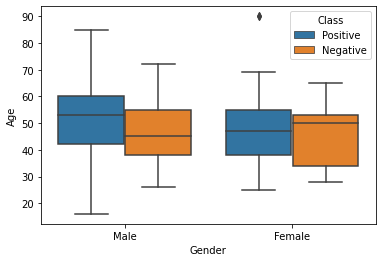

In [6]:
pdf=df_string.toPandas()
sns.boxplot(x='Gender', y='Age',hue='Class',data=pdf)

In [14]:
df_string.groupBy('Gender').count().show()
df.groupBy('Gender').count().show()
group = df_string.groupBy('Gender', 'Class').count()#.sort('Gender')#.collect()[1][2]  #.show()
groupRows=group.collect()
group.show()
# df_string.agg(F.count(F.when((F.col('Gender')=='Female') & (F.col('Class')==1),True))).show()

+------+-----+
|Gender|count|
+------+-----+
|Female|  192|
|  Male|  328|
+------+-----+

+------+-----+
|Gender|count|
+------+-----+
|     1|  328|
|     0|  192|
+------+-----+

+------+--------+-----+
|Gender|   Class|count|
+------+--------+-----+
|  Male|Positive|  147|
|Female|Positive|  173|
|Female|Negative|   19|
|  Male|Negative|  181|
+------+--------+-----+



In [12]:
male_pos = groupRows[0][2]
female_pos = groupRows[1][2]
female_neg = groupRows[2][2]
male_neg = groupRows[3][2]
print(groupRows)
values=[female_neg,male_neg,female_pos,male_pos]
print(values)

[Row(Gender='Male', Class='Positive', count=147), Row(Gender='Female', Class='Positive', count=173), Row(Gender='Female', Class='Negative', count=19), Row(Gender='Male', Class='Negative', count=181)]
[19, 181, 173, 147]


## Donut Chart
https://plotly.com/python/pie-charts/#donut-chart

In [13]:
import plotly.graph_objs as go
heart_data=df.toPandas()

male = heart_data[heart_data["Gender"]==1]
female = heart_data[heart_data["Gender"]==0]

# male_survi = male[heart_data["Class"]==0]
# male_not = male[heart_data["Class"]==1]
# female_survi = female[heart_data["Class"]==0]
# female_not = female[heart_data["Class"]==1]



labels = ["Female -  Negative", 'Male - Negative', "Female - Positive",'Male - Positive']
# values = [len(male[heart_data["Class"]==0]),len(male[heart_data["Class"]==1]),
#          len(female[heart_data["Class"]==0]),len(female[heart_data["Class"]==1])]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Analysis on Diagnosys - Gender")
fig.show()

# Manual indexing of the features

In [8]:
df_bin=df_string
for i in df_bin.columns[1:]: #to skip the first element 'Age'
    df_bin=df_bin.withColumn(i+'_', F.when(F.col(i) == "Positive", 1)
                                           .when(F.col(i) == "Negative",0)
                                           .when(F.col(i) == "Yes",1)
                                           .when(F.col(i) == "No",0)
                                           .when(F.col(i) == "Female",0)
                                           .when(F.col(i) == "Male",1)
                                           ).drop(i)
    df_bin=df_bin.withColumnRenamed(i+'_',i.replace(" ",'_'))
df_bin.show(5)
df_bin.printSchema()


+---+------+--------+----------+------------------+--------+----------+------------+---------------+-------+------------+---------------+---------------+----------------+--------+-------+-----+
|Age|Gender|Polyuria|Polydipsia|Sudden_weight_loss|Weakness|Polyphagia|Genital_rash|Visual_blurring|Itching|Irritability|Delayed_healing|Partial_paresis|Muscle_stiffness|Alopecia|Obesity|Class|
+---+------+--------+----------+------------------+--------+----------+------------+---------------+-------+------------+---------------+---------------+----------------+--------+-------+-----+
| 40|     1|       0|         1|                 0|       1|         0|           0|              0|      1|           0|              1|              0|               1|       1|      1|    1|
| 58|     1|       0|         0|                 0|       1|         0|           0|              1|      0|           0|              0|              1|               0|       1|      0|    1|
| 41|     1|       1|         

## SUM column
[Kaggle feature engineering](https://www.kaggle.com/ryanholbrook/creating-features)<br>
[how to do it from stackoveflow](https://stackoverflow.com/questions/31955309/add-column-sum-as-new-column-in-pyspark-dataframe/31955747)<br>
NOTE: it doesn-t work without "Manual indexing of the features"

In [9]:
print(df_bin.columns)
symptomsCols = [i for i in df_bin.columns if (i!='Age') and (i!='Gender') and (i!='Class')]
symp = ' + '.join(symptomsCols)
print(symp)

['Age', 'Gender', 'Polyuria', 'Polydipsia', 'Sudden_weight_loss', 'Weakness', 'Polyphagia', 'Genital_rash', 'Visual_blurring', 'Itching', 'Irritability', 'Delayed_healing', 'Partial_paresis', 'Muscle_stiffness', 'Alopecia', 'Obesity', 'Class']
Polyuria + Polydipsia + Sudden_weight_loss + Weakness + Polyphagia + Genital_rash + Visual_blurring + Itching + Irritability + Delayed_healing + Partial_paresis + Muscle_stiffness + Alopecia + Obesity


In [10]:
df = df_bin

# dfs = df.withColumn('summ', F.sum(df[c] for c in symptomsCols))

df = df_bin.withColumn('symptomsSum', F.expr(symp))

# dfs = df.select('*', (F.col("Polyuria")+F.col("Polydipsia")+F.col('Sudden weight loss').alias("total")))

# expression = '+'.join(symptomsCols)
# dfs = df.withColumn('sum_cols', F.expr(expression))
df.show(5)
df_bin.show(5)

+---+------+--------+----------+------------------+--------+----------+------------+---------------+-------+------------+---------------+---------------+----------------+--------+-------+-----+-----------+
|Age|Gender|Polyuria|Polydipsia|Sudden_weight_loss|Weakness|Polyphagia|Genital_rash|Visual_blurring|Itching|Irritability|Delayed_healing|Partial_paresis|Muscle_stiffness|Alopecia|Obesity|Class|symptomsSum|
+---+------+--------+----------+------------------+--------+----------+------------+---------------+-------+------------+---------------+---------------+----------------+--------+-------+-----+-----------+
| 40|     1|       0|         1|                 0|       1|         0|           0|              0|      1|           0|              1|              0|               1|       1|      1|    1|          7|
| 58|     1|       0|         0|                 0|       1|         0|           0|              1|      0|           0|              0|              1|               0|      

In [46]:
#RESTORE THE ORIGINAL BINARY DATAFRAME
# df=df_bin


## Mutual Information (Pandas)
https://www.kaggle.com/ryanholbrook/mutual-information <br>
https://it.wikipedia.org/wiki/Informazione_mutua


In [35]:
pdf = df.toPandas()
X = df.toPandas()
y = X.pop('Class')
discrete_features = [i for i in df.columns if (i!='Class')]
X.head()

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    color = np.array(["C0"] * scores.shape[0])
    # Color red for probes
    idx = [i for i, col in enumerate(scores.index)
           if col.startswith("PROBE")]
    color[idx] = "C3"
    # Create plot
    plt.barh(width, scores, color=color)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [21]:
 X.dtypes

Age                   int32
Gender                int32
Polyuria              int32
Polydipsia            int32
Sudden_weight_loss    int32
Weakness              int32
Polyphagia            int32
Genital_rash          int32
Visual_blurring       int32
Itching               int32
Irritability          int32
Delayed_healing       int32
Partial_paresis       int32
Muscle_stiffness      int32
Alopecia              int32
Obesity               int32
symptomsSum           int32
dtype: object

In [27]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

Polyuria              0.239737
Polydipsia            0.235987
symptomsSum           0.207664
Age                   0.136716
Gender                0.113274
Partial_paresis       0.107857
Sudden_weight_loss    0.106200
Polyphagia            0.090414
Alopecia              0.067632
Visual_blurring       0.051870
Weakness              0.028907
Muscle_stiffness      0.024900
Itching               0.018353
Genital_rash          0.012442
Irritability          0.000998
Delayed_healing       0.000000
Obesity               0.000000
Name: MI Scores, dtype: float64

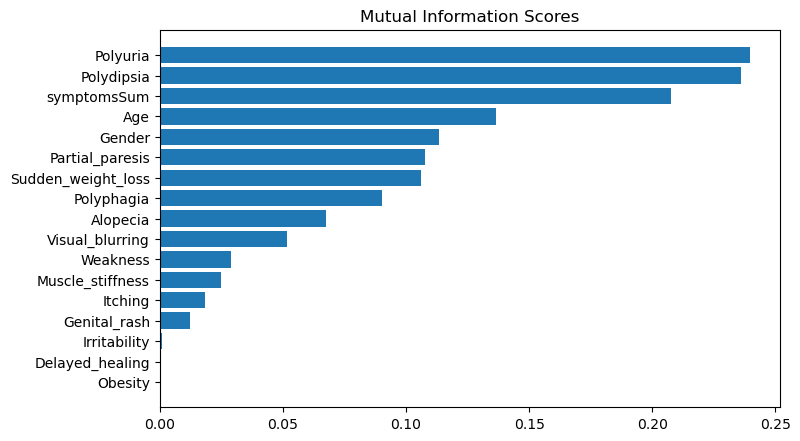

In [31]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

# CHI Squared


In [25]:
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler
columns=df.columns[1:-1] #remove age (because is numerical) and Class (because is target)

df2 = VectorAssembler(inputCols=columns, 
                               outputCol="features").transform(df)
df2.show(5)

r=ChiSquareTest.test(df2,'features','Class').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))
print()
l=[]
for i in range(len(columns)):
    #print(str(df.columns[i])+' = '+str(r.pValues[i]))
    l.append((columns[i],float(r.pValues[i]),float(r.degreesOfFreedom[i]),float(r.statistics[i])))
pValueDF=spark.createDataFrame(data=l,schema=['feature','pValue','degreesOfFreedom','statistics'])
pValueDF.show(truncate=False)


+---+------+--------+----------+------------------+--------+----------+------------+---------------+-------+------------+---------------+---------------+----------------+--------+-------+-----+--------------------+
|Age|Gender|Polyuria|Polydipsia|Sudden weight loss|Weakness|Polyphagia|Genital rash|Visual blurring|Itching|Irritability|Delayed healing|Partial paresis|Muscle stiffness|Alopecia|Obesity|Class|            features|
+---+------+--------+----------+------------------+--------+----------+------------+---------------+-------+------------+---------------+---------------+----------------+--------+-------+-----+--------------------+
| 40|     0|       0|         1|                 0|       1|         0|           0|              0|      1|           0|              1|              0|               1|       1|      1|    1|(15,[2,4,8,10,12,...|
| 58|     0|       0|         0|                 0|       1|         0|           0|              1|      0|           0|              0|   

# Features preparation

## TEES can handle categorical featurea 
considering that features are already manual indexed we only use VectorAssembler

In [34]:
from pyspark.ml.feature import VectorAssembler

MIsubset1 = ['Polyuria', 'Polydipsia', 'symptomsSum', 'Age', 'Gender', 'Partial_paresis', 'Sudden_weight_loss']
MIsubset2 = ['Polyuria', 'Polydipsia', 'symptomsSum', 'Age', 'Gender', 'Partial_paresis', 'Sudden_weight_loss',
             'Polyphagia','Alopecia','Visual_blurring']
 

assemblerInputsTree = [x for x in df_bin.columns if (x!= 'Class')]
df_tree_baseline=(VectorAssembler(inputCols=assemblerInputsTree,
                                    outputCol='features')
                                    .transform(df_bin)
                                    .withColumnRenamed('Class','label')
                                                                    ).select('label','features')
# df_tree_baseline.show(5,truncate=False)


assemblerInputsTree = [x for x in df.columns if (x!= 'Class')]
df_tree=(VectorAssembler(inputCols=assemblerInputsTree,
                        outputCol='features')
                        .transform(df)
                        .withColumnRenamed('Class','label')
                                                        ).select('label','features')
# df_tree.show(5,truncate=False)

assemblerInputsTree = MIsubset1
df_tree_sub1=(VectorAssembler(inputCols=assemblerInputsTree,
                        outputCol='features')
                        .transform(df)
                        .withColumnRenamed('Class','label')
                                                       ).select('label','features')
# df_tree_sub1.show(5,truncate=False)

assemblerInputsTree = MIsubset2
df_tree_sub2=(VectorAssembler(inputCols=assemblerInputsTree,
                        outputCol='features')
                        .transform(df)
                        .withColumnRenamed('Class','label')
                                                       ).select('label','features')
# df_tree_sub2.show(5,truncate=False)

## Logistic Regression and NaiveBayes need OneHotEncoder
we use OneHotEncoder e VectorAssembler

In [49]:
# df=df_bin

from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

#BASELINE
oheInputs = [x for x in df_bin.columns if (x!= 'Class') and (x!='Age')]
oheOutput = [x+'_ohe' for x in oheInputs]
assemblerInputsOHE = ['Age']+oheOutput

ohe = OneHotEncoder(inputCols=oheInputs, outputCols=oheOutput)
vecAss = VectorAssembler(inputCols=assemblerInputsOHE, outputCol='features')
df_ohe_baseline = (Pipeline(stages=[ohe,vecAss]).fit(df_bin).transform(df_bin)
                                               .withColumnRenamed('Class','label')
                                                                   .select('label','features'))
# df_ohe_baseline.show(5,truncate=False)

#SUM NUMERIC
oheInputs = [x for x in df.columns if (x!= 'Class') and (x!='Age') and (x!='symptomsSum')]
oheOutput = [x+'_ohe' for x in oheInputs]
assemblerInputsOHE = ['Age','symptomsSum']+oheOutput

ohe = OneHotEncoder(inputCols=oheInputs, outputCols=oheOutput)
vecAss = VectorAssembler(inputCols=assemblerInputsOHE, outputCol='features')
df_ohe_sumNum = (Pipeline(stages=[ohe,vecAss]).fit(df).transform(df)
                                               .withColumnRenamed('Class','label')
                                                                   .select('label','features'))
# df_ohe_sumNum.show(5,truncate=False)


#SUM CATEGORICAL
oheInputs = [x for x in df.columns if (x!= 'Class') and (x!='Age')]
oheOutput = [x+'_ohe' for x in oheInputs]
assemblerInputsOHE = ['Age']+oheOutput

ohe = OneHotEncoder(inputCols=oheInputs, outputCols=oheOutput)
vecAss = VectorAssembler(inputCols=assemblerInputsOHE, outputCol='features')
df_ohe_sumCat = (Pipeline(stages=[ohe,vecAss]).fit(df).transform(df)
                                               .withColumnRenamed('Class','label')
                                                                   .select('label','features'))
# df_ohe_sumCat.show(5,truncate=False)

## IMPORTS and EVALUATORS

In [18]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

bEvaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
bEvaluator2 = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderPR")

mEvaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

## Decision Tree
in the [documentation](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier) it uses StringIndexer and VectorIndexer

In [13]:
DTtrainDF, DTtestDF = df_tree.randomSplit([.8, .2], seed=42)
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
# pipeline = Pipeline(stages = [stringIndexer, vecAssembler, dt])


In [15]:
%%time

paramGrid = (ParamGridBuilder().build())

cv = CrossValidator(estimator=dt,
                    evaluator=bEvaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelDT=cv.fit(DTtrainDF)

CPU times: user 211 ms, sys: 49.4 ms, total: 260 ms
Wall time: 14.4 s


In [57]:
#take the best pipelineModel and extract the decisionTreeModel from the pipeline (the last element of the stages)
dt_model=cvModelDT.bestModel # .stages[-1] #no pipeline no stages

featureImp=pd.DataFrame(list(zip(assemblerInputsTree,dt_model.featureImportances)),                        
                        columns=['feature','importance'])
featureImp.sort_values(by='importance',ascending=False)

feature  importance
3           Polydipsia    0.473054
1               Gender    0.139837
2             Polyuria    0.120615
0                  Age    0.077815
6           Polyphagia    0.044430
14            Alopecia    0.034263
4   Sudden_weight_loss    0.030466
7         Genital_rash    0.026853
10        Irritability    0.021890
15             Obesity    0.011984
13    Muscle_stiffness    0.011740
11     Delayed_healing    0.007053
5             Weakness    0.000000
8      Visual_blurring    0.000000
9              Itching    0.000000
12     Partial_paresis    0.000000

In [58]:
print("Decision Tree average area under the ROC curve:", cvModelDT.avgMetrics)

Decision Tree average area under the ROC curve: [0.9711893002539455]


In [59]:
DTprediction=cvModelDT.transform(DTtestDF)
DTprediction.select('label', 'prediction', 'probability').show(10, truncate=False)
DTprediction.groupBy('label','prediction').count().show()

+-----+----------+---------------------+
|label|prediction|probability          |
+-----+----------+---------------------+
|0    |0.0       |[1.0,0.0]            |
|0    |0.0       |[0.9765625,0.0234375]|
|0    |0.0       |[0.9765625,0.0234375]|
|0    |0.0       |[0.9765625,0.0234375]|
|0    |0.0       |[0.9765625,0.0234375]|
|0    |0.0       |[0.9765625,0.0234375]|
|0    |0.0       |[0.9765625,0.0234375]|
|0    |0.0       |[0.9765625,0.0234375]|
|0    |0.0       |[0.9765625,0.0234375]|
|0    |0.0       |[0.9765625,0.0234375]|
+-----+----------+---------------------+
only showing top 10 rows

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    7|
|    0|       0.0|   29|
|    1|       1.0|   44|
|    0|       1.0|    2|
+-----+----------+-----+



In [60]:
# from sklearn.metrics import classification_report
# a=prediction.select('label','prediction','probability').toPandas()
# print(classification_report(a['label'],a['prediction']))

In [61]:
DT_areaUnderROC = bEvaluator.evaluate(DTprediction)
print("Decision Tree areaUnderROC = %g" % DT_areaUnderROC)
DT_areaUnderPR = bEvaluator2.evaluate(DTprediction)
print("Decision Tree areaUnderPR = %g" % DT_areaUnderPR)

print('Decision Tree accuracy = %g'% mEvaluator.evaluate(DTprediction))

Decision Tree areaUnderROC = 0.899114
Decision Tree areaUnderPR = 0.933561
Decision Tree accuracy = 0.890244


WITH SUM COLUMNS<br>
Decision Tree areaUnderROC = 0.908918<br>
Decision Tree areaUnderPR = 0.937712<br>
Decision Tree accuracy = 0.902439 <br>

WITHOUT SUM COLUMN <br>
Decision Tree areaUnderROC = 0.899114<br>
Decision Tree areaUnderPR = 0.933561<br>
Decision Tree accuracy = 0.890244

## Decisiontree LOOP

In [37]:
%%time
dt_loop_df = df_tree#_baseline #df_tree_sub1 #df_tree

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=8)
AUCavg=[]
AUPRavg=[]
ACCavg=[]
for i in range(100):
    DTtrainDF, DTtestDF = dt_loop_df.randomSplit([.8, .2], seed=i)

    modelDT=dt.fit(DTtrainDF)
    DTprediction=modelDT.transform(DTtestDF)
    AUCavg.append(bEvaluator.evaluate(DTprediction))
    AUPRavg.append(bEvaluator2.evaluate(DTprediction))
    ACCavg.append(mEvaluator.evaluate(DTprediction))
print('AUC = %g'% (sum(AUCavg)/len(AUCavg)))
print('AUPR = %g'% (sum(AUPRavg)/len(AUPRavg)))
print('ACC = %g'% (sum(ACCavg)/len(ACCavg)))

AUC = 0.958575
AUPR = 0.963307
ACC = 0.959732
CPU times: user 1.39 s, sys: 425 ms, total: 1.81 s
Wall time: 1min 58s


BASELINE:<br>
AUC = 0.949627<br>
AUPR = 0.966676<br>
ACC = 0.946047<br>

BASELINE x100: <br>
AUC = 0.950654
AUPR = 0.963706
ACC = 0.948528

WITH SUM COLUMN:<br>
AUC = 0.946557<br>
AUPR = 0.964133<br>
ACC = 0.943589<br>

WITH SUM COLUMN x100:<br>
AUC = 0.945235
AUPR = 0.958176
ACC = 0.944106

WITH SUM COLUMN maxDepth=8 x100:<br>
AUC = 0.958575
AUPR = 0.963307
ACC = 0.959732

SUBSET 1 x100:
AUC = 0.933777
AUPR = 0.941123
ACC = 0.936234

## Random Forest
[Algorithm official documentation](https://spark.apache.org/docs/3.0.1/mllib-ensembles.html#random-forests)<br>
Random forests are ensembles of decision trees. Random forests are one of the most successful machine learning models for classification and regression.<br>
[Ensembles official documentation](https://spark.apache.org/docs/3.0.1/ml-classification-regression.html#random-forests)<br>
Random forests are ensembles of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. The spark.ml implementation supports random forests for binary and multiclass classification and for regression, using both continuous and categorical features.

In [91]:
RFtrainDF, RFtestDF = df_tree.randomSplit([.8, .2], seed=42)

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
# pipeline = Pipeline(stages = [stringIndexer, vecAssembler, rf])

In [108]:
%%time
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

RFparamGrid = (ParamGridBuilder().addGrid(rf.maxDepth, [8]) #da 9 in poi resta costante
                                 .build())

cv = CrossValidator(estimator=rf,
                    evaluator=bEvaluator,
                    estimatorParamMaps=RFparamGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelRF=cv.fit(RFtrainDF)

CPU times: user 256 ms, sys: 84.1 ms, total: 340 ms
Wall time: 9.56 s


In [94]:
list(zip(cvModelRF.getEstimatorParamMaps(), cvModelRF.avgMetrics))

[({Param(parent='RandomForestClassifier_97d6a6085705', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 8},
  0.9722903534087745),
 ({Param(parent='RandomForestClassifier_97d6a6085705', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 9},
  0.9722903534087745)]

In [95]:
print("Random Forest average area under the ROC curve:", cvModelRF.avgMetrics)

Random Forest average area under the ROC curve: [0.9722903534087745, 0.9722903534087745]


In [96]:
rf_model=cvModelRF.bestModel #.stages[-1] #no pipeline no stages
featureImp=pd.DataFrame(list(zip(assemblerInputsTree,rf_model.featureImportances)),
                        columns=['feature','importance'])
featureImp.sort_values(by='importance',ascending=False)

feature  importance
2             Polyuria    0.255291
3           Polydipsia    0.156951
1               Gender    0.114256
0                  Age    0.096315
12     Partial_paresis    0.058632
6           Polyphagia    0.053319
4   Sudden_weight_loss    0.053150
14            Alopecia    0.036228
11     Delayed_healing    0.031532
10        Irritability    0.027432
9              Itching    0.024731
7         Genital_rash    0.022968
5             Weakness    0.020631
8      Visual_blurring    0.016852
15             Obesity    0.016071
13    Muscle_stiffness    0.015642

In [97]:
RFprediction=cvModelRF.transform(RFtestDF)
RFprediction.select('label', 'prediction', 'probability').show(truncate=False)
RFprediction.groupBy('label','prediction').count().show()

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0    |0.0       |[0.6108689175984572,0.38913108240154276] |
|0    |0.0       |[0.9653551789625061,0.03464482103749395] |
|0    |0.0       |[0.9653551789625061,0.03464482103749395] |
|0    |0.0       |[0.9653551789625061,0.03464482103749395] |
|0    |0.0       |[0.9653551789625061,0.03464482103749395] |
|0    |0.0       |[0.9653551789625061,0.03464482103749395] |
|0    |0.0       |[0.9224980361053632,0.07750196389463679] |
|0    |0.0       |[0.9518416654489925,0.04815833455100747] |
|0    |0.0       |[0.9518416654489925,0.04815833455100747] |
|0    |0.0       |[0.957397221004548,0.0426027789954519]   |
|0    |0.0       |[0.734271978021978,0.265728021978022]    |
|0    |0.0       |[0.734271978021978,0.265728021978022]    |
|0    |0.0       |[0.8313518099547512,0.16864819004524886] |
|0    |0.0       |[0.949

In [98]:
RF_areaUnderROC = bEvaluator.evaluate(RFprediction)
print("Random Forest areaUnderROC = %g" % RF_areaUnderROC)
RF_areaUnderPR = bEvaluator2.evaluate(RFprediction)
print("Random Forest areaUnderPR = %g" % RF_areaUnderPR)

print('Random Forest accuracy = %g'% mEvaluator.evaluate(RFprediction))

Random Forest areaUnderROC = 0.954459
Random Forest areaUnderPR = 0.969073
Random Forest accuracy = 0.95122


WITH SUM COLUMNS<br>
Random Forest areaUnderROC = 0.948134<br>
Random Forest areaUnderPR = 0.954141<br>
Random Forest accuracy = 0.95122<br>

WITHOUT SUM COLUMN <br>
Random Forest areaUnderROC = 0.954459<br>
Random Forest areaUnderPR = 0.969073<br>
Random Forest accuracy = 0.95122<br>

## RANDOM FOREST LOOP

In [38]:
%%time
rf_loop_df = df_tree#_sub2 # df_tree_baseline # df_tree

AUCavg=[]
AUPRavg=[]
ACCavg=[]
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=10, numTrees=100)
for i in range(50):
    cv = rf
    modelRF=rf.fit(RFtrainDF)
    RFprediction=modelRF.transform(RFtestDF)
    AUCavg.append(bEvaluator.evaluate(RFprediction))
    AUPRavg.append(bEvaluator2.evaluate(RFprediction))
    ACCavg.append(mEvaluator.evaluate(RFprediction))
print('AUC = %g'% (sum(AUCavg)/len(AUCavg)))
print('AUPR = %g'% (sum(AUPRavg)/len(AUPRavg)))
print('ACC = %g'% (sum(ACCavg)/len(ACCavg)))

AUC = 0.975652
AUPR = 0.977765
ACC = 0.97726
CPU times: user 787 ms, sys: 241 ms, total: 1.03 s
Wall time: 1min 28s


BASELINE (df_tree_baseline):<br>
AUC = 0.9734<br>
AUPR = 0.981193<br>
ACC = 0.972221<br>

BASELINE x100: <br>
AUC = 0.950498 <br>
AUPR = 0.95937 <br>
ACC = 0.950121 <br>

BASELINE x100 maxDepth=8: <br>
AUC = 0.969376 <br>
AUPR = 0.973337 <br>
ACC = 0.969565 <br>

BASELINE x100 maxDepth=7: <br>
AUC = 0.966475 <br>
AUPR = 0.97187 <br>
ACC = 0.966446 <br>

WITH SUM COLUMN:<br>
AUC = 0.971815<br>
AUPR = 0.977987<br>
ACC = 0.972087<br>

WITH SUM COLUMN (df_tree) x100 maxDepth=11: <br>
AUC = 0.971462 <br>
AUPR = 0.973736 <br>
ACC = 0.972703 <br>

**WITH SUM COLUMN (df_tree) x50 maxDepth=10 numTrees=100:** <br>
AUC = 0.975652 <br>
AUPR = 0.977765 <br>
ACC = 0.97726 <br>

WITH SUM COLUMN (df_tree) x100 maxDepth=10: <br>
AUC = 0.971552 <br>
AUPR = 0.973777 <br>
ACC = 0.97281 <br>

WITH SUM COLUMN (df_tree) x100 maxDepth=9:<br>
AUC = 0.971216 <br>
AUPR = 0.973332 <br>
ACC = 0.97265 <br>

WITH SUM COLUMN (df_tree) x100 maxDepth=8:<br>
AUC = 0.969251 <br>
AUPR = 0.972564 <br>
ACC = 0.970145 <br>

WITH SUM COLUMN (df_tree) x100 maxDepth=7:<br>
AUC = 0.966356 <br>
AUPR = 0.971959 <br>
ACC = 0.966028 <br>

WITH SUM COLUMN (df_tree) x100 maxDepth=6: <br>
AUC = 0.960844 <br>
AUPR = 0.969129 <br>
ACC = 0.959778 <br>

SUBSET 1 (sum) maxD=10 x100: <br>
AUC = 0.959576 <br>
AUPR = 0.96578 <br>
ACC = 0.959456 <br>

SUBSET 1 (sum) maxD=4 x100: <br>
AUC = 0.912585 <br>
AUPR = 0.922316 <br>
ACC = 0.915265 <br>

SUBSET 2 (sum) maxD=10 x100: <br>
AUC = 0.966504 <br>
AUPR = 0.970492 <br>
ACC = 0.967405 <br>


## Gradient-Boosted Trees (GBTs)
[Official documentation](https://spark.apache.org/docs/3.0.1/ml-classification-regression.html#gradient-boosted-trees-gbts) <br>
The spark.ml implementation supports GBTs for binary classification and for regression, using both continuous and categorical features

In [124]:
GBTtrainDF, GBTtestDF = df_tree.randomSplit([.8, .2], seed=42)
gbtc = GBTClassifier(labelCol="label", featuresCol="features")
# pipeline = Pipeline(stages = [stringIndexer, vecAssembler, gbtc])

In [126]:
%%time
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = (ParamGridBuilder().addGrid(gbtc.maxDepth, [8,9]) #da 9 in poi resta costante
                                 .build())

cv = CrossValidator(estimator=gbtc,
                    evaluator=bEvaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelGBT=cv.fit(GBTtrainDF)

CPU times: user 600 ms, sys: 231 ms, total: 831 ms
Wall time: 55.6 s


In [127]:
list(zip(cvModelGBT.getEstimatorParamMaps(), cvModelGBT.avgMetrics))

[({Param(parent='GBTClassifier_3418db79f599', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 8},
  0.9772968722310826),
 ({Param(parent='GBTClassifier_3418db79f599', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 9},
  0.9772968722310826)]

In [128]:
GBTprediction=cvModelGBT.transform(GBTtestDF)
GBTprediction.select('label', 'prediction', 'probability').show(truncate=False)
GBTprediction.groupBy('label','prediction').count().show()

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.9563534785727067,0.043646521427293306]|
|0    |0.0       |[0.956

In [129]:
GBT_areaUnderROC = bEvaluator.evaluate(GBTprediction)
print("Gradient-Boosted Trees areaUnderROC = %g" % GBT_areaUnderROC)
GBT_areaUnderPR = bEvaluator2.evaluate(GBTprediction)
print("Gradient-Boosted Trees areaUnderPR = %g" % GBT_areaUnderPR)

Gradient-Boosted Trees areaUnderROC = 0.932005
Gradient-Boosted Trees areaUnderPR = 0.936026


## Linear Support Vector Machine
WARNING: non so se è giusto usare **rFormula**

In [148]:

from pyspark.ml.classification import LinearSVC


lsvc = LinearSVC(featuresCol='features',labelCol='label',
                 maxIter=10, regParam=0.1)
# pipeline = Pipeline(stages = [rFormula, lsvc])

SVCtrainDF, SVCtestDF = df_ohe.randomSplit([.8, .2], seed=42)

In [149]:
%%time

paramGrid = (ParamGridBuilder().addGrid(lsvc.regParam, [0.0, 0.1])
                               .build())

cv = CrossValidator(estimator=lsvc,
                    evaluator=bEvaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelSVC=cv.fit(SVCtrainDF)

CPU times: user 394 ms, sys: 156 ms, total: 550 ms
Wall time: 10.8 s


In [150]:
list(zip(cvModelSVC.getEstimatorParamMaps(), cvModelSVC.avgMetrics))

[({Param(parent='LinearSVC_358eab1dfe57', name='regParam', doc='regularization parameter (>= 0).'): 0.0},
  0.8822210624909508),
 ({Param(parent='LinearSVC_358eab1dfe57', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
  0.8837091774144203)]

In [151]:
SVCprediction=cvModelSVC.transform(SVCtestDF)
#prediction.select('label', 'prediction', 'probability').show()
SVCprediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    6|
|    0|       0.0|   30|
|    1|       1.0|   45|
|    0|       1.0|    1|
+-----+----------+-----+



In [153]:
SVC_areaUnderROC = bEvaluator.evaluate(SVCprediction)
print("Linear Support Vector Machines areaUnderROC = %g" % SVC_areaUnderROC)
SVC_areaUnderPR = bEvaluator2.evaluate(SVCprediction)
print("Linear Support Vector Machine areaUnderPR = %g" % SVC_areaUnderPR)

Linear Support Vector Machines areaUnderROC = 0.925047
Linear Support Vector Machine areaUnderPR = 0.957301


## Logistic Regression
10 folds

[Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8) from exploration to evaluation <br>

In [49]:
from pyspark.ml.feature import RFormula

# rFormula = RFormula(formula="Class ~ .",
#                     #featuresCol="features", 
#                     #labelCol="Class1", 
#                     handleInvalid="skip")

lr = LogisticRegression(labelCol="label", featuresCol="features")
# pipeline = Pipeline(stages = [rFormula, lr])


ohe_trainDF, ohe_testDF = df_ohe.randomSplit([.8, .2], seed=42)

In [110]:
%%time

#here we only try 2 parameters for lr.regParam
LRparamGrid = (ParamGridBuilder()
#                                .addGrid(lr.regParam, [0.0,0.2])
                               .build())

cv = CrossValidator(estimator=lr,
                    evaluator=bEvaluator,
                    estimatorParamMaps=LRparamGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelLR=cv.fit(ohe_trainDF)

CPU times: user 169 ms, sys: 32.2 ms, total: 201 ms
Wall time: 14.1 s


In [51]:
list(zip(cvModelLR.getEstimatorParamMaps(), cvModelLR.avgMetrics))

[({}, 0.9145076045696924)]

In [52]:
LRprediction=cvModelLR.transform(ohe_testDF)
#prediction.select('label', 'prediction', 'probability').show()
LRprediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    3|
|    0|       0.0|   28|
|    1|       1.0|   48|
|    0|       1.0|    3|
+-----+----------+-----+



In [53]:
LR_areaUnderROC = bEvaluator.evaluate(LRprediction)
print("Logistic Regression areaUnderROC = %g" % LR_areaUnderROC)
LR_areaUnderPR = bEvaluator2.evaluate(LRprediction)
print("Logistic Regression areaUnderPR = %g" % LR_areaUnderPR)

print('Logistic Regression accuracy = %g'% mEvaluator.evaluate(LRprediction))

Logistic Regression areaUnderROC = 0.922201
Logistic Regression areaUnderPR = 0.931787
Logistic Regression accuracy = 0.926829


WITH SUM COLUMN<br>
Logistic Regression areaUnderROC = 0.948134 <br>
Logistic Regression areaUnderPR = 0.954141 <br>
Logistic Regression accuracy = 0.95122<br>

WITHOUT SUM COLUMN <br>
Logistic Regression areaUnderROC = 0.922201 <br>
Logistic Regression areaUnderPR = 0.931787 <br>
Logistic Regression accuracy = 0.926829

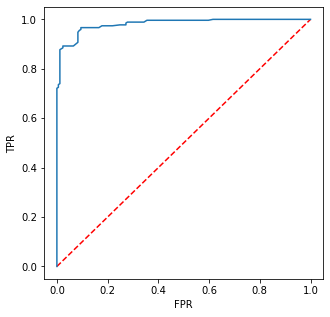

In [80]:
import matplotlib.pyplot as plt

lr_model=cvModelLR.bestModel   #.stages[1] #no pipeline no stages

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')  #the red line
plt.plot(lr_model.summary.roc.select('FPR').collect(),
         lr_model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### WARNING l'area sotto la curva risulta più alta di quella di pyspark
[vedi articolo su handyspark](https://towardsdatascience.com/binary-classifier-evaluation-made-easy-with-handyspark-3b1e69c12b4f)

Area under ROC Curve: 0.9831


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

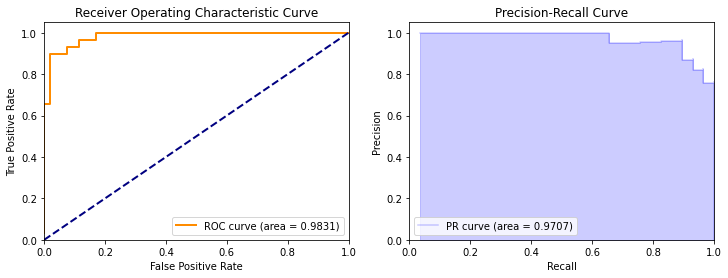

In [20]:
from handyspark import BinaryClassificationMetrics
import matplotlib.pyplot as plt

bcm = BinaryClassificationMetrics(prediction, scoreCol='probability', labelCol='label')
# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
# print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

## Logistic Regression LOOP

In [52]:
%%time
lr_loop_df = df_ohe_sumCat #_baseline

AUCavg=[]
AUPRavg=[]
ACCavg=[]
lr = LogisticRegression(labelCol="label", featuresCol="features")
for i in range(100):
    LRtrainDF, LRtestDF = lr_loop_df.randomSplit([.8, .2], seed=i)

    modelLR=lr.fit(LRtrainDF)
    LRprediction=modelLR.transform(LRtestDF)
    AUCavg.append(bEvaluator.evaluate(LRprediction))
    AUPRavg.append(bEvaluator2.evaluate(LRprediction))
    ACCavg.append(mEvaluator.evaluate(LRprediction))
print('AUC = %g'% (sum(AUCavg)/len(AUCavg)))
print('AUPR = %g'% (sum(AUPRavg)/len(AUPRavg)))
print('ACC = %g'% (sum(ACCavg)/len(ACCavg)))

AUC = 0.937277
AUPR = 0.946052
ACC = 0.938741
CPU times: user 1.53 s, sys: 414 ms, total: 1.94 s
Wall time: 5min 15s


BASELINE x100 (df_ohe_baseline): <br>
AUC = 0.921577 <br>
AUPR = 0.93154 <br>
ACC = 0.923786 <br>

WITH SUM COLUMN x100 (df_ohe_sumNum): <br>
AUC = 0.922545 <br>
AUPR = 0.932615 <br>
ACC = 0.924304 <br>

WITH SUM COLUMN x100 (df_ohe_sumCat): <br>
AUC = 0.937277 <br>
AUPR = 0.946052 <br>
ACC = 0.938741 <br>

# Naive Bayes

In [134]:
nb = NaiveBayes(featuresCol='features',labelCol='label')

NBtrainDF, NBtestDF = df_ohe.randomSplit([.8, .2], seed=42)

In [135]:
%%time

NBparamGrid = (ParamGridBuilder().build())

cv = CrossValidator(estimator=nb,
                    evaluator=bEvaluator,
                    estimatorParamMaps=NBparamGrid,
                    numFolds=10,
                    seed=42,
                    parallelism=20)
cvModelNB=cv.fit(NBtrainDF)

CPU times: user 121 ms, sys: 19.6 ms, total: 141 ms
Wall time: 10.8 s


In [84]:
list(zip(cvModelNB.getEstimatorParamMaps(), cvModelNB.avgMetrics))

[({}, 0.8219479206873204)]

In [85]:
NBprediction=cvModelNB.transform(NBtestDF)
NBprediction.select('label', 'prediction', 'probability').show(truncate=False)
NBprediction.groupBy('label','prediction').count().show()

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |1.0       |[0.3128925487808455,0.6871074512191544] |
|0    |0.0       |[0.7977047317269468,0.20229526827305327]|
|0    |0.0       |[0.7977047317269468,0.20229526827305327]|
|0    |0.0       |[0.5648400956591673,0.4351599043408326] |
|0    |1.0       |[0.4941157645917695,0.5058842354082305] |
|0    |1.0       |[0.41644639240544423,0.5835536075945558]|
|0    |1.0       |[0.33981905804498697,0.6601809419550131]|
|0    |1.0       |[0.11886661413208184,0.8811333858679181]|
|0    |0.0       |[0.5669629641067632,0.43303703589323683]|
|0    |0.0       |[0.5669629641067632,0.43303703589323683]|
|0    |0.0       |[0.5669629641067632,0.43303703589323683]|
|0    |0.0       |[0.9815469548445073,0.01845304515549277]|
|0    |0.0       |[0.9815469548445073,0.01845304515549277]|
|0    |0.0       |[0.9601137613561502,0.

In [86]:
NB_areaUnderROC = bEvaluator.evaluate(NBprediction)
print("Naive Bayes areaUnderROC = %g" % NB_areaUnderROC)
NB_areaUnderPR = bEvaluator2.evaluate(NBprediction)
print("Naive Bayes areaUnderPR = %g" % NB_areaUnderPR)

print('Naive Bayes accuracy = %g'% mEvaluator.evaluate(NBprediction))

Naive Bayes areaUnderROC = 0.850727
Naive Bayes areaUnderPR = 0.879017
Naive Bayes accuracy = 0.853659


WITH SUM COLUMNS<br>
Naive Bayes areaUnderROC = 0.892789<br>
Naive Bayes areaUnderPR = 0.918938<br>
Naive Bayes accuracy = 0.890244<br>

WITHOUT SUM COLUMN <br>
Naive Bayes areaUnderROC = 0.850727<br>
Naive Bayes areaUnderPR = 0.879017<br>
Naive Bayes accuracy = 0.853659

## NAIVE BAYES LOOP

In [55]:
%%time
nb_loop_df = df_ohe_sumCat
AUCavg=[]
AUPRavg=[]
ACCavg=[]
nb = NaiveBayes(featuresCol='features',labelCol='label')
for i in range(100):
    NBtrainDF, NBtestDF = nb_loop_df.randomSplit([.8, .2], seed=i)

    modelNB=nb.fit(NBtrainDF)
    NBprediction=modelNB.transform(NBtestDF)
    AUCavg.append(bEvaluator.evaluate(NBprediction))
    AUPRavg.append(bEvaluator2.evaluate(NBprediction))
    ACCavg.append(mEvaluator.evaluate(NBprediction))
print('AUC = %g'% (sum(AUCavg)/len(AUCavg)))
print('AUPR = %g'% (sum(AUPRavg)/len(AUPRavg)))
print('ACC = %g'% (sum(ACCavg)/len(ACCavg)))

AUC = 0.830797
AUPR = 0.858372
ACC = 0.832442
CPU times: user 1.08 s, sys: 302 ms, total: 1.39 s
Wall time: 2min 31s


BASELINE x100 (df_ohe_baseline): <br>
AUC = 0.823617 <br>
AUPR = 0.85353 <br>
ACC = 0.823604 <br>

WITH SUM COLUMN x100 (df_ohe_sumNum): <br>
AUC = 0.805499 <br>
AUPR = 0.839554 <br>
ACC = 0.806908 <br>

WITH SUM COLUMN x100 (df_ohe_sumCat): <br>
AUC = 0.830797 <br>
AUPR = 0.858372 <br>
ACC = 0.832442 <br>

### Baseline Results

In [174]:
pdf = pd.DataFrame({
    'metric': ['AUC','AUC','AUC','AUC',
               'AUPR','AUPR','AUPR','AUPR',
               'ACC','ACC','ACC','ACC'],
    'value':  [0.906466,0.949627,0.9734,0.817217,  
               0.918683,0.966676,0.981193,0.855884,  
               0.913885,0.946047,0.972221,0.820094],
    'Algorithm':  ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes']
})
pdf.head(12)

metric     value            Algorithm
0     AUC  0.906466  Logistic Regression
1     AUC  0.949627        Decision Tree
2     AUC  0.973400        Random Forest
3     AUC  0.817217          Naive Bayes
4    AUPR  0.918683  Logistic Regression
5    AUPR  0.966676        Decision Tree
6    AUPR  0.981193        Random Forest
7    AUPR  0.855884          Naive Bayes
8     ACC  0.913885  Logistic Regression
9     ACC  0.946047        Decision Tree
10    ACC  0.972221        Random Forest
11    ACC  0.820094          Naive Bayes

<AxesSubplot:xlabel='metric', ylabel='value'>

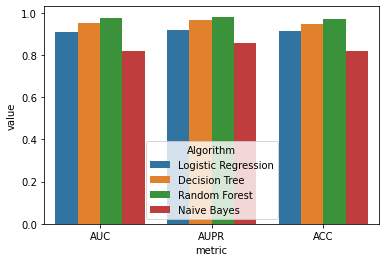

In [175]:
sns.barplot(data=pdf, x='metric',y='value',hue='Algorithm')

In [176]:
fig = px.bar(pdf, x='metric', y='value',color='Algorithm',barmode='group',text='value')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
# fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')



fig.show()

### Con feature sintetica

In [177]:
pdf = pd.DataFrame({
    'metric': ['AUC','AUC','AUC','AUC',
               'AUPR','AUPR','AUPR','AUPR',
               'ACC','ACC','ACC','ACC'],
    'value':  [0.947078,0.946557,0.971815,0.855316,
               0.958157,0.964133,0.977987,0.892738,
               0.947867,0.943589,0.972087,0.85047],
    'Algorithm':  ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes']
})
pdf.head(12)

metric     value            Algorithm
0     AUC  0.947078  Logistic Regression
1     AUC  0.946557        Decision Tree
2     AUC  0.971815        Random Forest
3     AUC  0.855316          Naive Bayes
4    AUPR  0.958157  Logistic Regression
5    AUPR  0.964133        Decision Tree
6    AUPR  0.977987        Random Forest
7    AUPR  0.892738          Naive Bayes
8     ACC  0.947867  Logistic Regression
9     ACC  0.943589        Decision Tree
10    ACC  0.972087        Random Forest
11    ACC  0.850470          Naive Bayes

In [178]:
fig = px.bar(pdf, x='metric', y='value',color='Algorithm',barmode='group',text='value')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
# fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [179]:
pdf = pd.DataFrame({
    'metric': ['AUC','AUC','AUC','AUC',
               'AUPR','AUPR','AUPR','AUPR',
               'ACC','ACC','ACC','ACC',
               'AUC','AUC','AUC','AUC',
               'AUPR','AUPR','AUPR','AUPR',
               'ACC','ACC','ACC','ACC'],
    'value':  [0.906466,0.949627,0.9734,0.817217,  
               0.918683,0.966676,0.981193,0.855884,  
               0.913885,0.946047,0.972221,0.820094,
               0.947078,0.946557,0.971815,0.855316,
               0.958157,0.964133,0.977987,0.892738,
               0.947867,0.943589,0.972087,0.85047],
    'Algorithm':  ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes',
                   'Logistic Regression','Decision Tree','Random Forest','Naive Bayes'],
    'features': ['baseline','baseline','baseline','baseline',
                 'baseline','baseline','baseline','baseline',
                 'baseline','baseline','baseline','baseline',
                 'synthetic','synthetic','synthetic','synthetic',
                 'synthetic','synthetic','synthetic','synthetic',
                 'synthetic','synthetic','synthetic','synthetic',]
})
pdf.head(12)

metric     value            Algorithm  features
0     AUC  0.906466  Logistic Regression  baseline
1     AUC  0.949627        Decision Tree  baseline
2     AUC  0.973400        Random Forest  baseline
3     AUC  0.817217          Naive Bayes  baseline
4    AUPR  0.918683  Logistic Regression  baseline
5    AUPR  0.966676        Decision Tree  baseline
6    AUPR  0.981193        Random Forest  baseline
7    AUPR  0.855884          Naive Bayes  baseline
8     ACC  0.913885  Logistic Regression  baseline
9     ACC  0.946047        Decision Tree  baseline
10    ACC  0.972221        Random Forest  baseline
11    ACC  0.820094          Naive Bayes  baseline

In [181]:
fig = px.bar(pdf, x='metric', y='value',color='Algorithm',barmode='group',text='value', facet_col='features')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
# fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [198]:
spark.stop()